# Portfolio Optimization

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from returns import Returns
from risks import Risks
from metrics import Metrics
from optimizer import Optimizer

## Import data

In [41]:
df_raw_all = pd.read_hdf("dow30_full_selected.h5")


In [42]:
df_raw_prices = df_raw_all[["date", "tic", "close"]].rename(columns={"close": "price"})


In [43]:
df_prices = df_raw_prices.pivot(index="date", columns="tic", values="price").loc[
    "2009-01-02":"2020-01-01"
]


## Solve and check summary

In [50]:
def construct_portfolio(
    df_prices: pd.DataFrame,
    rfr: float,
    freq: str = "monthly",
    objective: str = "quadratic_utility",
    constraints: list = [],
    objective_kwargs: dict={},
    constraint_kwargs:list=[],
) -> tuple:
    """
    Global function to solve portfolio problem

    Parameters
    ----------
    df_prices : pd.DataFrame
        DataFrame containing asset prices
    rfr : float
        Risk free rate of return
    freq : str, optional
        Frequency of portfolio rebalancing, by default "monthly"
    objective : str, optional
        Objective of investor, by default "quadratic_utility"
    constraint : list, optional
        Constraints of investor

    Returns
    -------
    tuple
        Tuple of dicts: weights and portfolio metrics
    """
    # Convert to same time scale
    if freq == "monthly":
        t = 12
        ts = 20
    elif freq == "yearly":
        t = 1
        ts = 252
    elif freq == "daily":
        t = 252
        ts = 1

    # Input data
    returns_generator = Returns(df_prices)
    df_returns = returns_generator.compute_returns(method="daily")
    # rfr_daily = ((1 + rfr) ** (1 / 252)) - 1
    # rfr_effective = ((1 + rfr) ** (1 / t)) - 1
    # df_returns["RF"] = rfr_daily
    mu_return_geom = returns_generator.compute_mean_return(
        method="geometric", time_scaling=ts
    )
    # mu_return_geom["RF"] = rfr_effective
    cov_generator = Risks(df_returns)
    cov_matrix = cov_generator.compute_cov_matrix(time_scaling=ts)

    # Construct optimizer
    portfolio_problem = Optimizer(
        mu_return_geom, cov_matrix, asset_names=list(mu_return_geom.index)
    )

    # print(portfolio_problem.objective_options())
    # print(portfolio_problem.constraint_options())

    portfolio_problem.clear_problem()
    portfolio_problem.add_objective(objective, **objective_kwargs)
    for c, kwarg in zip(constraints, constraint_kwargs):
        portfolio_problem.add_constraint(c, **kwarg)

    # Solve problem
    portfolio_problem.solve()

    return portfolio_problem.summary(rfr=0.01/12)


## Solve min. variance

In [51]:
roll = 120 * 20
trade_len = 16 * 20

In [52]:
res_minvar = []
rtrn_minvar = []
i = 0
np.random.seed(42)
while i < len(range(trade_len)):
    w_minvar, perf_minvar = construct_portfolio(
        df_prices[i : roll + i], 0.0000, "monthly", "min_variance", ["weight"], {}, [{"weight_bound":(-1, 1), "sum":1}]
    )
    i += 20
    print(perf_minvar)
    res_minvar.append(w_minvar)
    rtrn_minvar.append(perf_minvar["Expected return"])
df_weights_minvar = pd.DataFrame(res_minvar)

{'Expected return': 0.005, 'Sum': 1.0, 'Num. holdings': 4, 'Volatility': 0.0413, 'Correlation': 0.5806, 'Sharpe Ratio': 0.1001}
{'Expected return': 0.0061, 'Sum': 1.0001, 'Num. holdings': 4, 'Volatility': 0.0405, 'Correlation': 0.5717, 'Sharpe Ratio': 0.1311}
{'Expected return': 0.0064, 'Sum': 0.9999, 'Num. holdings': 4, 'Volatility': 0.041, 'Correlation': 0.6472, 'Sharpe Ratio': 0.1367}
{'Expected return': 0.0061, 'Sum': 1.0001, 'Num. holdings': 4, 'Volatility': 0.0391, 'Correlation': 0.5782, 'Sharpe Ratio': 0.1358}
{'Expected return': 0.0058, 'Sum': 1.0, 'Num. holdings': 4, 'Volatility': 0.0387, 'Correlation': 0.5493, 'Sharpe Ratio': 0.1285}
{'Expected return': 0.0065, 'Sum': 1.0, 'Num. holdings': 4, 'Volatility': 0.0391, 'Correlation': 0.5987, 'Sharpe Ratio': 0.1446}
{'Expected return': 0.0052, 'Sum': 1.0, 'Num. holdings': 4, 'Volatility': 0.0396, 'Correlation': 0.5929, 'Sharpe Ratio': 0.1096}
{'Expected return': 0.0054, 'Sum': 1.0, 'Num. holdings': 4, 'Volatility': 0.0392, 'Correla

C:\Users\simon.therien\AppData\Local\Temp\ipykernel_2876\4050585102.py:75: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, return_matrix).shape[1], repeats=return_matrix.shape[1]


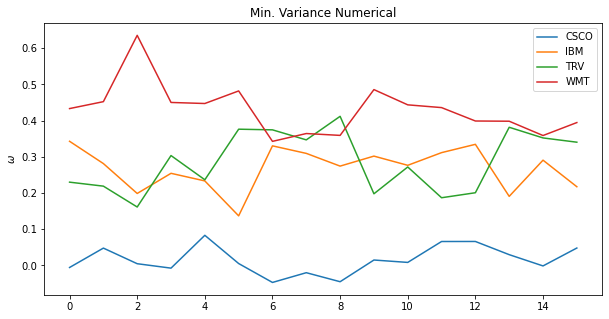

In [53]:
df_weights_minvar.plot.line(figsize=(10, 5))
plt.ylabel("$\omega$")
plt.title("Min. Variance Numerical")
plt.show()


## Exact solution min. variance

In [54]:
res_gmv = []
i = 0
while i < len(range(trade_len)):
    returns_generator = Returns(df_prices[i : roll + i])
    df_returns = returns_generator.compute_returns(method="daily")
    mu_return_geom = returns_generator.compute_mean_return(
        method="geometric", time_scaling=20
    )
    cov_generator = Risks(df_returns)
    cov_matrix = cov_generator.compute_cov_matrix(time_scaling=20)

    inverse_cov_df = np.linalg.pinv(cov_matrix)

    n_assets = len(cov_matrix)

    numerator = np.matmul(np.ones(n_assets).T, inverse_cov_df)
    denominator = np.matmul(np.ones(n_assets).T, (np.matmul(inverse_cov_df, np.ones(n_assets))))
    gmv_w = numerator / denominator
    i += 20
    res_gmv.append(gmv_w)
df_weights_gmv = pd.DataFrame(res_gmv, columns=cov_matrix.columns)


C:\Users\simon.therien\AppData\Local\Temp\ipykernel_2876\4050585102.py:75: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, return_matrix).shape[1], repeats=return_matrix.shape[1]


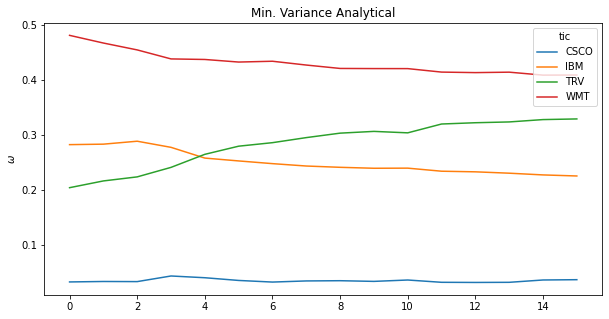

In [55]:
df_weights_gmv.plot.line(figsize=(10, 5))
plt.ylabel("$\omega$")
plt.title("Min. Variance Analytical")
plt.show()


## Compare min. variance

In [56]:
df_weights_gmv.mean(axis=0)

tic
CSCO    0.035037
IBM     0.250180
TRV     0.284100
WMT     0.430683
dtype: float64

In [57]:
df_weights_minvar.mean(axis=0)

CSCO    0.015544
IBM     0.267700
TRV     0.286831
WMT     0.429912
dtype: float64

In [58]:
init_w = 1000000
cum_w_minvar = init_w * np.cumprod(1 + np.array(rtrn_minvar))
print("Final wealth ", cum_w_minvar[-1])

Final wealth  1092916.5158595867


## Solve quadratic

In [69]:
res_qu = []
rtrn_qu = []
i = 0
np.random.seed(42)
while i < len(range(trade_len)):
    w_qu, perf_qu = construct_portfolio(
        df_prices[i : roll + i], 0.0000, "monthly", "quadratic_utility", ["weight"], {"aversion": 3}, [{"weight_bound":(-2, 2), "sum":1}]
    )
    i += 20
    print(perf_qu)
    res_qu.append(w_qu)
    rtrn_qu.append(perf_qu["Expected return"])
df_weights_qu = pd.DataFrame(res_qu)

{'Expected return': 0.0082, 'Sum': 1.0, 'Num. holdings': 4, 'Volatility': 0.0527, 'Correlation': 0.7477, 'Sharpe Ratio': 0.1398}
{'Expected return': 0.0104, 'Sum': 0.9999, 'Num. holdings': 4, 'Volatility': 0.0551, 'Correlation': 0.8358, 'Sharpe Ratio': 0.1745}
{'Expected return': 0.0123, 'Sum': 0.9999, 'Num. holdings': 4, 'Volatility': 0.0587, 'Correlation': 0.9941, 'Sharpe Ratio': 0.1954}
{'Expected return': 0.0111, 'Sum': 1.0, 'Num. holdings': 4, 'Volatility': 0.0565, 'Correlation': 0.9722, 'Sharpe Ratio': 0.1817}
{'Expected return': 0.0126, 'Sum': 1.0, 'Num. holdings': 4, 'Volatility': 0.0614, 'Correlation': 1.301, 'Sharpe Ratio': 0.1909}
{'Expected return': 0.0137, 'Sum': 1.0, 'Num. holdings': 4, 'Volatility': 0.0643, 'Correlation': 1.4327, 'Sharpe Ratio': 0.2}
{'Expected return': 0.0124, 'Sum': 1.0, 'Num. holdings': 4, 'Volatility': 0.0619, 'Correlation': 1.353, 'Sharpe Ratio': 0.1869}
{'Expected return': 0.012, 'Sum': 1.0, 'Num. holdings': 4, 'Volatility': 0.0604, 'Correlation': 

C:\Users\simon.therien\AppData\Local\Temp\ipykernel_2876\4050585102.py:75: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, return_matrix).shape[1], repeats=return_matrix.shape[1]


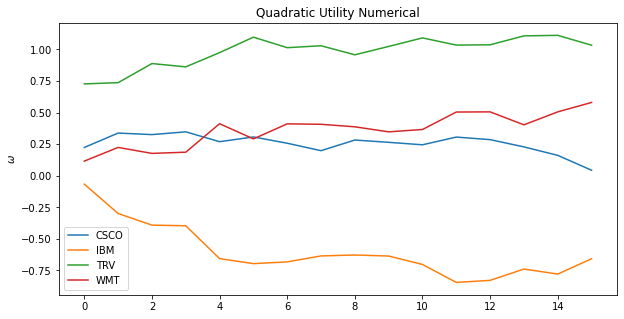

In [72]:
df_weights_qu.plot.line(figsize=(10, 5))
plt.ylabel("$\omega$")
plt.title("Quadratic Utility Numerical")
plt.show()

## Exact solution quadratic

In [61]:
res_quadratic = []
i = 0
while i < len(range(trade_len)):
    returns_generator = Returns(df_prices[i : roll + i])
    df_returns = returns_generator.compute_returns(method="daily")
    mu_return_geom = returns_generator.compute_mean_return(
        method="geometric", time_scaling=20
    )
    cov_generator = Risks(df_returns)
    cov_matrix = cov_generator.compute_cov_matrix(time_scaling=20)

    inverse_cov_df = np.linalg.pinv(cov_matrix)

    n_assets = len(cov_matrix)

    aversion = 3
    numerator_mvp = np.matmul(np.ones(n_assets).T, inverse_cov_df)
    denominator_mvp = np.matmul(np.ones(n_assets).T, (np.matmul(inverse_cov_df, np.ones(n_assets))))
    mvp_w = numerator_mvp / denominator_mvp
    numerator_tangency = np.matmul(mu_return_geom.T, inverse_cov_df)
    denominator_tangency = np.matmul(np.ones(n_assets).T, (np.matmul(inverse_cov_df, mu_return_geom)))
    tangency_w = numerator_tangency / denominator_tangency
    quadratic_w = mvp_w + (1 / aversion) * denominator_tangency * (tangency_w - mvp_w) 
    i += 20
    res_quadratic.append(quadratic_w)
df_weights_quadratic = pd.DataFrame(res_quadratic, columns=cov_matrix.columns)

C:\Users\simon.therien\AppData\Local\Temp\ipykernel_2876\4050585102.py:75: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, return_matrix).shape[1], repeats=return_matrix.shape[1]


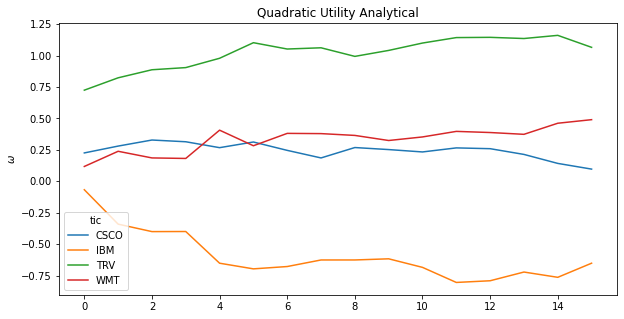

In [73]:
df_weights_quadratic.plot.line(figsize=(10, 5))
plt.ylabel("$\omega$")
plt.title("Quadratic Utility Analytical")
plt.show()


## Compare quadratic

In [71]:
df_weights_qu.mean(axis=0)

CSCO    0.255306
IBM    -0.602313
TRV     0.982912
WMT     0.364088
dtype: float64

In [64]:
df_weights_quadratic.mean(axis=0)

tic
CSCO    0.242984
IBM    -0.595463
TRV     1.019836
WMT     0.332643
dtype: float64

In [65]:
cum_w_qu = init_w * np.cumprod(1 + np.array(rtrn_qu))
print("Final wealth ", cum_w_qu[-1])

Final wealth  1214939.5027798514
